## Face and Facial Keypoint detection

After you've trained a neural network to detect facial keypoints, you can then apply this network to *any* image that includes faces. The neural network expects a Tensor of a certain size as input and, so, to detect any face, you'll first have to do some pre-processing.

1. Detect all the faces in an image using a face detector (we'll be using a Haar Cascade detector in this notebook).
2. Pre-process those face images so that they are grayscale, and transformed to a Tensor of the input size that your net expects. This step will be similar to the `data_transform` you created and applied in Notebook 2, whose job was tp rescale, normalize, and turn any iimage into a Tensor to be accepted as input to your CNN.
3. Use your trained model to detect facial keypoints on the image.

---

In the next python cell we load in required libraries for this section of the project.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


#### Select an image 

Select an image to perform facial keypoint detection on; you can select any image of faces in the `images/` directory.

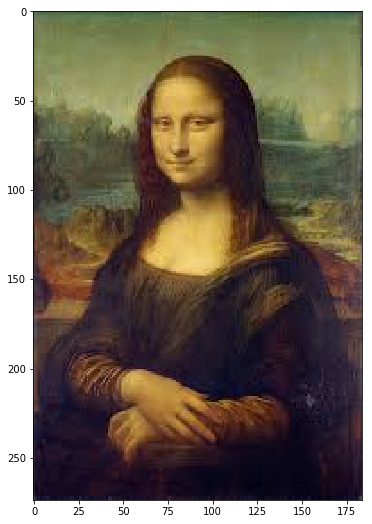

In [10]:
import cv2
# load in color image for face detection
# image = cv2.imread('images/obamas.jpg')
image = cv2.imread('images/mona_lisa.jpg')

# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

## Detect all faces in an image

Next, you'll use one of OpenCV's pre-trained Haar Cascade classifiers, all of which can be found in the `detector_architectures/` directory, to find any faces in your selected image.

In the code below, we loop over each face in the original image and draw a red square on each face (in a copy of the original image, so as not to modify the original). You can even [add eye detections](https://docs.opencv.org/3.4.1/d7/d8b/tutorial_py_face_detection.html) as an *optional* exercise in using Haar detectors.

An example of face detection on a variety of images is shown below.

<img src='images/haar_cascade_ex.png' width=80% height=80%/>


可以发现这里奥巴马夫妇的脸并没有完全包括到矩形区域里面，如果直接将矩形区域传入模型，那么预测的关键点

~~**下巴的轮廓将和下嘴唇非常靠近！**~~

实际上是，整个预测关键点的scatter图像感觉向中心缩小了！主要是因为，**训练数据基本没有这种haar_cascade输出的这种图像——绝大部分区域的都是人脸**，所以

需要增大输入模型的矩形区域。对于haar_cascade得到的人脸区域，左右上下个增加`60`个像素点，或者将宽高扩大两倍。

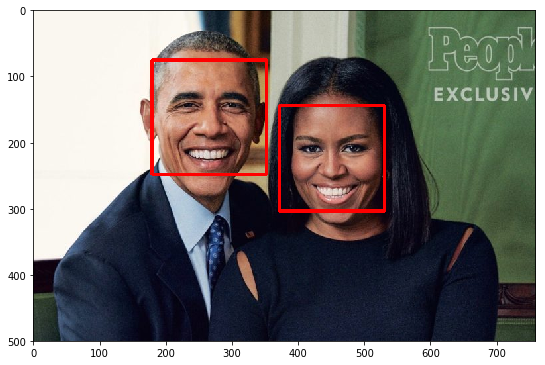

In [3]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image
faces = face_cascade.detectMultiScale(image, 1.2, 2)

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    # you may also need to change the width of the rectangle drawn depending on image resolution
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

## Loading in a trained model

Once you have an image to work with (and, again, you can select any image of faces in the `images/` directory), the next step is to pre-process that image and feed it into your CNN facial keypoint detector.

First, load your best model by its filename.

In [4]:
import torch
from models import AlexNet
from data_load import DeNormalize

denormalize = DeNormalize("CENTER", 227)
net = AlexNet()

## TODO: load the best saved model parameters (by your path name)
## You'll need to un-comment the line below and add the correct name for *your* saved model
# net.load_state_dict(torch.load('saved_models/keypoints_model_1.pt'))
net.load_state_dict(torch.load('saved_models/{}_keypoints_model.pt'.format(denormalize.norm_method), map_location=lambda storage, loc: storage))
## print out your net and prepare it for testing (uncomment the line below)
net.eval()

AlexNet(
  (conv1): Conv2d(1, 96, kernel_size=(4, 4), stride=(4, 4))
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=136, bias=True)
  (dropout2): Dropout(p=0.2)
  (dropout4): Dropout(p=0.4)
  (dropout6): Dropout(p=0.6)
  (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_runn

## Keypoint detection

Now, we'll loop over each detected face in an image (again!) only this time, you'll transform those faces in Tensors that your CNN can accept as input images.

### TODO: Transform each detected face into an input Tensor

You'll need to perform the following steps for each detected face:
1. Convert the face from RGB to grayscale
2. Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
3. Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
4. Reshape the numpy image into a torch image.

You may find it useful to consult to transformation code in `data_load.py` to help you perform these processing steps.


### TODO: Detect and display the predicted keypoints

After each face has been appropriately converted into an input Tensor for your network to see as input, you'll wrap that Tensor in a Variable() and can apply your `net` to each face. The ouput should be the predicted the facial keypoints. These keypoints will need to be "un-normalized" for display, and you may find it helpful to write a helper function like `show_keypoints`. You should end up with an image like the following with facial keypoints that closely match the facial features on each individual face:

<img src='images/michelle_detected.png' width=30% height=30%/>




In [5]:
def show_all_keypoints(img, predicted_key_points):
    """Show image with predicted key points."""
    plt.imshow(img, cmap='gray')
    plt.scatter(predicted_key_points[:, 0], predicted_key_points[:, 1], c='m', s=20, marker='.')

In [8]:
import cv2
from torch.autograd import Variable

def detect_pts():
    net.load_state_dict(torch.load('saved_models/{}_keypoints_model.pt'.format(denormalize.norm_method), map_location=lambda storage, loc: storage))
    net.eval()
    
    image_copy = np.copy(image)

    # loop over the detected faces from your haar cascade
    for i, (x,y,w,h) in enumerate(faces):

        # Select the region of interest that is the face in the image 
        roi = image_copy[y-30:y+h+30, x-30:x+w+30]

        ## TODO: Convert the face region from RGB to grayscale
        roi_g = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        # update h, w to new height and width of region of interest
        h, w = roi_g.shape

        ## TODO: Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
        roi_g = roi_g / 255.0

        ## TODO: Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
        roi_g = np.expand_dims(cv2.resize(roi_g, (227, 227)), axis=0)
        roi_g = torch.from_numpy(roi_g)

        ## TODO: Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)

        ## TODO: Make facial keypoint predictions using your loaded, trained network 
        ## perform a forward pass to get the predicted facial keypoints
        roi_g_copy = np.copy(roi_g)

        net.eval()
        roi_g = roi_g.type(torch.FloatTensor)
        roi_g = roi_g.unsqueeze(0)

        output_pts = net.forward(Variable(roi_g))
        output_pts = output_pts.view(68, 2)
        output_pts = output_pts.data.numpy()

        ## TODO: Display each detected face and the corresponding keypoints        
        output_pts = denormalize(output_pts)
        output_pts = output_pts * (w / 227, h / 227)

        print("output_pts.shape = ", output_pts.shape)
        print("roi.shape = ", roi.shape)

        plt.figure(figsize=(10, 8))
        if (i == 0):
            plt.subplot(2, 1, 1)
            show_all_keypoints(np.squeeze(roi), output_pts)
        elif (i == 1):
            plt.subplot(2, 1, 2)
            show_all_keypoints(np.squeeze(roi), output_pts)
        plt.show() 

output_pts.shape =  (68, 2)
roi.shape =  (115, 115, 3)


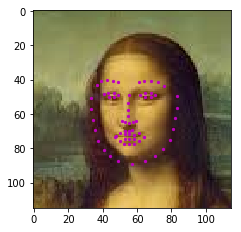

In [17]:
detect_pts() # epoch 42

output_pts.shape =  (68, 2)
roi.shape =  (115, 115, 3)


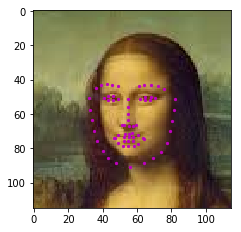

In [18]:
detect_pts() # epoch 49